In [40]:
# Import libraries, features and settings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
import pandas as pd
import time
import io
from sklearn.neural_network import MLPRegressor, MLPClassifier
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, mutual_info_classif, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
plt.rc("font", size = 14)
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)

In [41]:
# read in the train & test csvs as dataframes

df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

df_train

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C23,C24,C25,C26,C27,C28,C29,C30,regression target,classification target
0,divorced,Holders of other higher courses,second choice,Management,daytime,Higher education - degree,65.00,Portuguese,no,no,...,5.0,5,0.0,0.000000,0,11.1,0.6,2.02,0.6500,failure
1,single,Over 23 years old,second choice,Veterinary Nursing,daytime,Secondary education,65.00,Portuguese,no,no,...,6.0,14,2.0,11.333333,0,11.1,0.6,2.02,0.5500,success
2,single,1st phase - general contingent,seventh choice,Communication Design,daytime,Frequency of higher education,59.50,Portuguese,yes,no,...,6.0,8,6.0,13.625000,0,10.8,1.4,1.74,0.6160,success
3,married,Over 23 years old,second choice,Social Service,daytime,Basic education 3rd cycle (9th/10th/11th year)...,66.55,Portuguese,no,no,...,6.0,0,0.0,0.000000,0,15.5,2.8,-4.06,0.5175,failure
4,single,1st phase - general contingent,fourth choice,Nursing,daytime,Secondary education,71.00,Portuguese,yes,no,...,7.0,7,6.0,13.900000,0,7.6,2.6,0.32,0.6865,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,single,1st phase - general contingent,third choice,Communication Design,daytime,Secondary education,67.00,Portuguese,yes,no,...,6.0,11,4.0,11.333333,0,13.9,NaN,0.79,0.6385,failure
3535,single,1st phase - general contingent,second choice,Basic Education,daytime,Secondary education,66.50,Portuguese,yes,no,...,8.0,8,8.0,12.625000,0,15.5,2.8,-4.06,0.6565,success
3536,single,1st phase - general contingent,second choice,Social Service (evening attendance),evening,Secondary education,50.00,Portuguese,no,no,...,6.0,6,NaN,12.500000,0,12.7,3.7,-1.70,0.5640,success
3537,single,1st phase - general contingent,fifth choice,Social Service,daytime,Secondary education,63.50,Portuguese,yes,no,...,6.0,7,6.0,13.428571,0,11.1,0.6,2.02,0.6020,success


Part 2 - [Q7]

In [42]:
# Get the numerical and categorical features
num_features = df_train.select_dtypes(include=['float64', 'int64'])
cat_features = df_train.select_dtypes(include=['object'])

In [43]:
# Find out which features are binary
bin_features = cat_features.nunique()
bin_features = bin_features[bin_features == 2]
bin_features = bin_features.drop('classification target')
bin_features = cat_features[bin_features.index]

# Store ordinal features
ord_features = cat_features[['C2', 'C5']]

# Store nominal features
nom_features = cat_features[['C0', 'C1', 'C3', 'C7']]

# Store continuous features
cont_features = num_features[['C6','C20', 'C26', 'C28', 'C29', 'C30', 'regression target']]

# Store discrete features
disc_features = num_features[['C14', 'C16', 'C17', 'C18', 'C19', 'C21', 'C22', 'C23', 'C24', 'C25', 'C27']]

In [44]:
# Remove non empty features from the binary, ordinal, nominal, continuous and discrete features
bin_missing = bin_features.columns[bin_features.isnull().any()]
ord_missing = ord_features.columns[ord_features.isnull().any()]
nom_missing = nom_features.columns[nom_features.isnull().any()]
cont_missing = cont_features.columns[cont_features.isnull().any()]
disc_missing = disc_features.columns[disc_features.isnull().any()]

# Make an imputed df
df_imputed = df_train.copy()

# Impute the missing values in binary features
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(bin_features[bin_missing])
df_imputed[bin_missing] = imputer.transform(bin_features[bin_missing])

# Impute the missing values in the ordinal features
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(ord_features[ord_missing])
df_imputed[ord_missing] = imputer.transform(ord_features[ord_missing])

# Impute the missing values in the nominal features
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(nom_features[nom_missing])
df_imputed[nom_missing] = imputer.transform(nom_features[nom_missing])

# Impute the missing values in the continuous features
imputer = SimpleImputer(strategy='mean')
imputer = imputer.fit(cont_features[cont_missing])
df_imputed[cont_missing] = imputer.transform(cont_features[cont_missing])

# Impute the missing values in the discrete features
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(disc_features[disc_missing])
df_imputed[disc_missing] = imputer.transform(disc_features[disc_missing])


# Check if there are any missing values left
print(df_imputed.isnull().sum()[df_imputed.isnull().sum() > 0])


Series([], dtype: int64)


In [45]:
# Select the numerical features
imputed_nf = df_imputed.select_dtypes(include=['float64', 'int64'])

# Report first 10 samples of first numerical feature
print("Before:")
print(imputed_nf.iloc[:, 0].head(10))

# Initialize scalers
robust = RobustScaler()
standard = StandardScaler()

# Apply the RobustScaler to the discrete features
df_imputed[disc_features.columns] = robust.fit_transform(imputed_nf[disc_features.columns])

# Apply the StandardScaler to the continuous features
df_imputed[cont_features.columns] = standard.fit_transform(imputed_nf[cont_features.columns])

# Report first 10 samples of first numerical feature after scaling
print("After:")
print(df_imputed[imputed_nf.columns].iloc[:, 0].head(10))


Before:
0    65.00
1    65.00
2    59.50
3    66.55
4    71.00
5    70.00
6    57.50
7    65.50
8    70.00
9    80.00
Name: C6, dtype: float64
After:
0   -0.200135
1   -0.200135
2   -1.031074
3    0.034039
4    0.706344
5    0.555264
6   -1.333234
7   -0.124595
8    0.555264
9    2.066063
Name: C6, dtype: float64


In [46]:
# Select the numerical features
imputed_df = df_imputed.select_dtypes(include=['object'])
# Report first 10 samples of first numerical feature
print(imputed_df.iloc[:, 0].head(10))

# Initialize the encoders
onehot = OneHotEncoder(sparse_output=False)
ordinal = OrdinalEncoder(
categories = 
[
    ['first choice', 'second choice', 'third choice', 'fourth choice', 'fifth choice', 'sixth choice', 'seventh choice', 'last choice'],
    ['Basic education 2nd cycle (6th/7th/8th year) or equiv.', 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 'Secondary education', '10th year of schooling - not completed', '10th year of schooling', '11th year of schooling - not completed', 'Other - 11th year of schooling', '12th year of schooling - not completed', 'Technological specialization course', 'Professional higher technical course', 'Frequency of higher education', 'Higher education - degree', 'Higher education - degree (1st cycle)', "Higher education - bachelor's degree", 'Higher education - master (2nd cycle)', "Higher education - master's", 'Higher education - doctorate']
]
)
# Apply the OneHotEncoder to the nominal features
onehot_encoded = onehot.fit_transform(imputed_df[nom_features.columns])
onehot_encoded_nom = pd.DataFrame(onehot_encoded, columns=onehot.get_feature_names_out(nom_features.columns))

# Apply the OneHotEncoder to the binary features
onehot_encoded = onehot.fit_transform(imputed_df[bin_features.columns])
onehot_encoded_bin = pd.DataFrame(onehot_encoded, columns=onehot.get_feature_names_out(bin_features.columns))

# Apply the OrdinalEncoder to the ordinal features
ordinal_encoded = ordinal.fit_transform(imputed_df[ord_features.columns])
ordinal_encoded_df = pd.DataFrame(ordinal_encoded, columns=ord_features.columns)
df_imputed[ord_features.columns] = ordinal_encoded_df

# Apply label encoder to the classification target
label = LabelEncoder()
label_encoded = label.fit_transform(df_imputed['classification target'])
df_imputed['classification target'] = label_encoded

# Merge the standardised results
df_merged = pd.concat([df_imputed, onehot_encoded_nom, onehot_encoded_bin], axis=1)

# Drop the original columns
df_merged = df_merged.drop(nom_features.columns, axis=1)
df_merged = df_merged.drop(bin_features.columns, axis=1)

# Report the first 10 samples of the first categorical feature after encoding (all columns starting with C0)
print(df_merged.filter(regex='^C0_').head(10))


0    divorced
1      single
2      single
3     married
4      single
5      single
6      single
7      single
8      single
9      single
Name: C0, dtype: object
   C0_divorced  C0_facto union  C0_legally separated  C0_married  C0_single  \
0          1.0             0.0                   0.0         0.0        0.0   
1          0.0             0.0                   0.0         0.0        1.0   
2          0.0             0.0                   0.0         0.0        1.0   
3          0.0             0.0                   0.0         1.0        0.0   
4          0.0             0.0                   0.0         0.0        1.0   
5          0.0             0.0                   0.0         0.0        1.0   
6          0.0             0.0                   0.0         0.0        1.0   
7          0.0             0.0                   0.0         0.0        1.0   
8          0.0             0.0                   0.0         0.0        1.0   
9          0.0             0.0                

In [47]:
df_merged

,C2,C5,C6,C14,C16,C17,C18,C19,C20,C21,...,C10_no,C10_yes,C11_no,C11_yes,C12_female,C12_male,C13_no,C13_yes,C15_no,C15_yes
0,1.0,11.0,-0.200135,2.500000,0.0,-0.5,-0.75,-1.666667,-2.244836e+00,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,2.0,-0.200135,0.833333,0.0,0.0,1.25,-0.666667,2.201216e-01,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,6.0,10.0,-1.031074,0.333333,0.0,0.0,-0.50,0.333333,7.483267e-01,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,1.0,0.034039,3.666667,0.0,0.0,-2.00,-1.666667,-2.244836e+00,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,3.0,2.0,0.706344,0.333333,0.0,0.5,-0.25,0.333333,3.753123e-16,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,2.0,2.0,0.102025,-0.333333,1.0,0.0,0.00,0.333333,2.301826e-01,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3535,1.0,2.0,0.026485,0.000000,0.0,0.0,0.25,0.000000,7.835404e-01,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3536,1.0,2.0,-2.466332,0.500000,0.0,0.0,-0.50,0.333333,7.483267e-01,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3537,4.0,2.0,-0.426755,-0.166667,0.0,0.0,-0.50,0.333333,6.074720e-01,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


[Q10]

In [48]:

no_target = df_merged.drop(columns=['regression target', 'classification target'])
reg = df_merged['regression target']

# Initialize the SelectKBest method with a scoring function suitable for regression
selector = SelectKBest(score_func=f_regression, k=20)

# fit and get features
selector.fit_transform(no_target, reg)
selected_features_reg = no_target.columns[selector.get_support()]

# Now for the classification targets
class_t = df_merged['classification target']

# Initialize the SelectKBest method with a scoring function suitable for classification
selector = SelectKBest(score_func=mutual_info_classif, k=20)

# Fit the selector, transform data, get features
selector.fit_transform(no_target, class_t)
selected_class_feats = no_target.columns[selector.get_support()]


# now varthreshold
vthresh = VarianceThreshold(threshold=0.5)

# Fit adn select features
vthresh.fit_transform(no_target)
selected_var_feats = no_target.columns[vthresh.get_support()]

all_selected_feats = []
all_selected_feats.extend(selected_features_reg)
all_selected_feats.extend(selected_class_feats)
all_selected_feats.extend(selected_var_feats)

# Remove duplicates
all_selected_feats = list(set(all_selected_feats))
print(all_selected_feats)

df_selected = df_merged[all_selected_feats + ['regression target', 'classification target']]

reg_removed_feats = list(set(df_merged.columns) - set(selected_features_reg))
class_removed_feats = list(set(df_merged.columns) - set(selected_class_feats))
var_removed_feats = list(set(df_merged.columns) - set(selected_var_feats))

print("SelectKBest reg removed features:" + str(reg_removed_feats))
print("SelectKBest class removed features:" + str(class_removed_feats))
print("VarianceThreshold removed features:" + str(var_removed_feats))

df_selected

['C20', 'C3_Veterinary Nursing', 'C3_Management', 'C13_yes', 'C25', 'C10_no', 'C28', 'C3_Advertising and Marketing Management', 'C26', 'C2', 'C18', 'C1_2nd phase - general contingent', 'C7_Cuban', 'C27', 'C11_no', 'C30', 'C1_1st phase - general contingent', 'C1_Change of course', 'C17', 'C14', 'C19', 'C12_female', 'C3_Animation and Multimedia Design', 'C1_Ordinance No. 854-B/99', 'C23', 'C6', 'C3_Tourism', 'C1_Over 23 years old', 'C5', 'C24', 'C11_yes', 'C1_Technological specialization diploma holders', 'C10_yes', 'C22', 'C3_Agronomy', 'C16', 'C29']
SelectKBest reg removed features:['C7_Italian', 'C13_no', 'classification target', 'C10_no', 'C1_Ordinance No. 533-A/99, item b3 (Other Institution)', 'C1_1st phase - special contingent (Azores Island)', 'C3_Social Service', 'C7_German', 'C3_Oral Hygiene', 'C9_no', 'C7_Lithuanian', 'C3_Communication Design', 'C27', 'C7_Spanish', 'C1_Ordinance No. 533-A/99, item b2) (Different Plan)', 'C1_Transfer', 'C30', 'C1_1st phase - general contingent'

,C20,C3_Veterinary Nursing,C3_Management,C13_yes,C25,C10_no,C28,C3_Advertising and Marketing Management,C26,C2,...,C24,C11_yes,C1_Technological specialization diploma holders,C10_yes,C22,C3_Agronomy,C16,C29,regression target,classification target
0,-2.244836e+00,0.0,1.0,0.0,-1.25,1.0,-0.173556,0.0,-1.962344,1.0,...,-0.75,1.0,0.0,0.0,0.0,0.0,0.0,-4.707388e-01,0.217354,0
1,2.201216e-01,1.0,0.0,1.0,-0.75,1.0,-0.173556,0.0,0.212145,1.0,...,1.50,1.0,0.0,0.0,0.0,0.0,0.0,-4.707388e-01,-1.163519,1
2,7.483267e-01,0.0,0.0,0.0,0.25,1.0,-0.285968,0.0,0.651839,6.0,...,0.00,1.0,0.0,0.0,0.0,0.0,0.0,1.221149e-01,-0.252143,1
3,-2.244836e+00,0.0,0.0,0.0,-1.25,1.0,1.475143,0.0,-1.962344,1.0,...,-2.00,1.0,0.0,0.0,0.0,0.0,0.0,1.159609e+00,-1.612303,0
4,3.753123e-16,0.0,0.0,1.0,0.25,1.0,-1.485022,0.0,0.704602,3.0,...,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,1.011395e+00,0.721373,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3534,2.301826e-01,0.0,0.0,0.0,-0.25,1.0,0.875616,0.0,0.212145,2.0,...,0.75,0.0,0.0,0.0,0.0,0.0,1.0,-1.645499e-16,0.058553,0
3535,7.835404e-01,0.0,0.0,0.0,0.75,1.0,1.475143,0.0,0.459973,1.0,...,0.00,1.0,0.0,0.0,4.0,0.0,0.0,1.159609e+00,0.307111,1
3536,7.483267e-01,0.0,0.0,1.0,0.00,1.0,0.425971,0.0,0.435989,1.0,...,-0.50,1.0,0.0,0.0,0.0,0.0,0.0,1.826569e+00,-0.970197,1
3537,6.074720e-01,0.0,0.0,1.0,0.25,1.0,-0.173556,0.0,0.614151,4.0,...,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,-4.707388e-01,-0.445465,1


In [49]:
# Split df_selected into train and test
picked_features = ['C6', 'C4_daytime', 'C9_no', 'C12_male', 'C28', 'C29']
x = df_merged[picked_features]
y = df_merged['regression target']
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=4211)

# Select 6 individual features
f1 = trainX[picked_features[0]]
f2 = trainX[picked_features[1]]
f3 = trainX[picked_features[2]]
f4 = trainX[picked_features[3]]
f5 = trainX[picked_features[4]]
f6 = trainX[picked_features[5]]

# Select the test data features
f1_test = testX[picked_features[0]]
f2_test = testX[picked_features[1]]
f3_test = testX[picked_features[2]]
f4_test = testX[picked_features[3]]
f5_test = testX[picked_features[4]]
f6_test = testX[picked_features[5]]


In [50]:
# create a linear regression model for f1
f1model = linear_model.LinearRegression()
f1reg = f1model.fit(f1.to_numpy().reshape(-1, 1), trainY)

# create a linear regression model for f2
f2model = linear_model.LinearRegression()
f2reg = f2model.fit(f2.to_numpy().reshape(-1, 1), trainY)

# create a linear regression model for f3
f3model = linear_model.LinearRegression()
f3reg = f3model.fit(f3.to_numpy().reshape(-1, 1), trainY)

# create a linear regression model for f4
f4model = linear_model.LinearRegression()
f4reg = f4model.fit(f4.to_numpy().reshape(-1, 1), trainY)

# create a linear regression model for f5
f5model = linear_model.LinearRegression()
f5reg = f5model.fit(f5.to_numpy().reshape(-1, 1), trainY)

# create a linear regression model for f6
f6model = linear_model.LinearRegression()
f6reg = f6model.fit(f6.to_numpy().reshape(-1, 1), trainY)

# create a linear regression model for all features and get time for Q16
start = time.time()
allmodel = linear_model.LinearRegression()
allreg = allmodel.fit(trainX, trainY)
end = time.time()
linear_reg_time = end - start


In [51]:
# get the predictions
f1pred = f1reg.predict(f1_test.to_numpy().reshape(-1, 1))
f2pred = f2reg.predict(f2_test.to_numpy().reshape(-1, 1))
f3pred = f3reg.predict(f3_test.to_numpy().reshape(-1, 1))
f4pred = f4reg.predict(f4_test.to_numpy().reshape(-1, 1))
f5pred = f5reg.predict(f5_test.to_numpy().reshape(-1, 1))
f6pred = f6reg.predict(f6_test.to_numpy().reshape(-1, 1))
allpred = allreg.predict(testX)

# get r^2 scores
f1r2 = r2_score(testY, f1pred)
f2r2 = r2_score(testY, f2pred)
f3r2 = r2_score(testY, f3pred)
f4r2 = r2_score(testY, f4pred)
f5r2 = r2_score(testY, f5pred)
f6r2 = r2_score(testY, f6pred)
allr2 = r2_score(testY, allpred)

# print r^2 scores
print("R^2 score for f1: " + str(f1r2))
print("R^2 score for f2: " + str(f2r2))
print("R^2 score for f3: " + str(f3r2))
print("R^2 score for f4: " + str(f4r2))
print("R^2 score for f5: " + str(f5r2))
print("R^2 score for f6: " + str(f6r2))
print("R^2 score for all features: " + str(allr2))


R^2 score for f1: 0.3457983455467899
R^2 score for f2: -0.0003744371420333348
R^2 score for f3: -0.00038420655713355956
R^2 score for f4: 1.7846745361538296e-05
R^2 score for f5: 0.0025504461422434233
R^2 score for f6: 0.0006419687473383506
R^2 score for all features: 0.34860539017166103


In [52]:
# get the mean squared error of each model
f1mse = mean_squared_error(testY, f1pred)
f2mse = mean_squared_error(testY, f2pred)
f3mse = mean_squared_error(testY, f3pred)
f4mse = mean_squared_error(testY, f4pred)
f5mse = mean_squared_error(testY, f5pred)
f6mse = mean_squared_error(testY, f6pred)
allmse = mean_squared_error(testY, allpred)

# print the mean squared error of each model
print("Mean squared error for f1: " + str(f1mse))
print("Mean squared error for f2: " + str(f2mse))
print("Mean squared error for f3: " + str(f3mse))
print("Mean squared error for f4: " + str(f4mse))
print("Mean squared error for f5: " + str(f5mse))
print("Mean squared error for f6: " + str(f6mse))
print("Mean squared error for all features: " + str(allmse))



Mean squared error for f1: 0.6068057192641646
Mean squared error for f2: 0.9278987995999811
Mean squared error for f3: 0.9279078612355126
Mean squared error for f4: 0.9275349360957756
Mean squared error for f5: 0.9251858197519514
Mean squared error for f6: 0.9269560308029808
Mean squared error for all features: 0.6042020408402309


[Q14]

In [53]:
# make test & train model from the onehot encoded C0 split nominal features (now all binary)
x_c0 = df_merged[['C0_divorced', 'C0_married', 'C0_single', 'C0_facto union', 'C0_legally separated', 'C0_widower']]
y_c0 = df_merged['regression target']
trainX_c0, testX_c0, trainY_c0, testY_c0 = train_test_split(x_c0, y_c0, test_size=0.2, random_state=4211)


In [54]:
# create a linear regression model for C0
C0model = linear_model.LinearRegression()
C0reg = C0model.fit(trainX_c0, trainY_c0)

In [55]:
# get the prediction
C0pred = C0reg.predict(testX_c0)

# get the r^2 score
C0r2 = r2_score(testY_c0, C0pred)

# print the r^2 score
print("R^2 score for C0: " + str(C0r2))

R^2 score for C0: 0.002965640471848774


In [56]:
# get the mean squared error
C0mse = mean_squared_error(testY, C0pred)

# print the mean squared error
print("Mean squared error for C0: " + str(C0mse))

Mean squared error for C0: 0.9248007056329399


6.2

In [57]:
# create ffnn models
mlp1 = MLPRegressor(hidden_layer_sizes=(1,1,1), early_stopping=True)
mlp2 = MLPRegressor(hidden_layer_sizes=(8,8,8), early_stopping=True)
mlp3 = MLPRegressor(hidden_layer_sizes=(32,32,32), early_stopping=True)
mlp4 = MLPRegressor(hidden_layer_sizes=(128,128,128), early_stopping=True)

H = [1, 8, 32, 128]
rscores = []
times = []

In [58]:
tempr = []
temptime = []
for i in range(3):
    # train model 1 and get its training time
    start = time.time()
    mlp1.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp1pred = mlp1.predict(testX)
    # get r^2 score
    mlp1r2 = r2_score(testY, mlp1pred)
    tempr.append(mlp1r2)
# print time taken & r2 score
meanrscore = np.mean(tempr)
sdr = np.std(tempr)
elapsed_time = np.mean(temptime)
times.append(elapsed_time)
sdtime = np.std(temptime) 
rscores.append(meanrscore)
print("Mean Time taken for model 1: " + str(elapsed_time))
print("Standard deviation of Time taken for model 1: " + str(sdtime))
print("Mean R^2 score for model 1: " + str(meanrscore))
print("Standard deviation of R^2 score for model 1: " + str(sdr))


/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Time taken for model 1: 0.5829554398854574
Standard deviation of Time taken for model 1: 0.2674871914094547
Mean R^2 score for model 1: 0.22964324646426792
Standard deviation of R^2 score for model 1: 0.16377891446363466


In [59]:
tempr = []
temptime = []
for i in range(3):
    # train model 2 and get its training time
    start = time.time()
    mlp2.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp1pred = mlp2.predict(testX)
    # get r^2 score
    mlp2r2 = r2_score(testY, mlp1pred)
    tempr.append(mlp2r2)
# print time taken & r2 score
meanrscore = np.mean(tempr)
sdr = np.std(tempr)
elapsed_time = np.mean(temptime)
times.append(elapsed_time)
sdtime = np.std(temptime) 
rscores.append(meanrscore)
print("Mean Time taken for model 2: " + str(elapsed_time))
print("Standard deviation of Time taken for model 2: " + str(sdtime))
print("Mean R^2 score for model 2: " + str(meanrscore))
print("Standard deviation of R^2 score for model 2: " + str(sdr))


Mean Time taken for model 2: 0.2043320337931315
Standard deviation of Time taken for model 2: 0.10491688434062109
Mean R^2 score for model 2: 0.3703320479358287
Standard deviation of R^2 score for model 2: 0.021219390687395433


In [60]:
tempr = []
temptime = []
for i in range(3):
    # train model 3 and get its training time
    start = time.time()
    mlp3.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp3pred = mlp3.predict(testX)
    # get r^2 score
    mlp3r2 = r2_score(testY, mlp1pred)
    tempr.append(mlp3r2)
# print time taken & r2 score
meanrscore = np.mean(tempr)
sdr = np.std(tempr)
elapsed_time = np.mean(temptime)
times.append(elapsed_time)
sdtime = np.std(temptime) 
rscores.append(meanrscore)
print("Mean Time taken for model 3: " + str(elapsed_time))
print("Standard deviation of Time taken for model 3: " + str(sdtime))
print("Mean R^2 score for model 3: " + str(meanrscore))
print("Standard deviation of R^2 score for model 3: " + str(sdr))


Mean Time taken for model 3: 0.25440144538879395
Standard deviation of Time taken for model 3: 0.03128145123521301
Mean R^2 score for model 3: 0.3790031886624224
Standard deviation of R^2 score for model 3: 5.551115123125783e-17


In [61]:
tempr = []
temptime = []
for i in range(3):
    # train model 4 and get its training time
    start = time.time()
    mlp4.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp4pred = mlp4.predict(testX)
    # get r^2 score
    mlp4r2 = r2_score(testY, mlp4pred)
    tempr.append(mlp4r2)
# print time taken & r2 score
meanrscore = np.mean(tempr)
sdr = np.std(tempr)
elapsed_time = np.mean(temptime)
times.append(elapsed_time)
sdtime = np.std(temptime) 
rscores.append(meanrscore)
print("Mean Time taken for model 4: " + str(elapsed_time))
print("Standard deviation of Time taken for model 4: " + str(sdtime))
print("Mean R^2 score for model 4: " + str(meanrscore))
print("Standard deviation of R^2 score for model 4: " + str(sdr))


Mean Time taken for model 4: 1.1119808355967205
Standard deviation of Time taken for model 4: 0.630263321187976
Mean R^2 score for model 4: 0.4027646595813678
Standard deviation of R^2 score for model 4: 0.008610459111680962


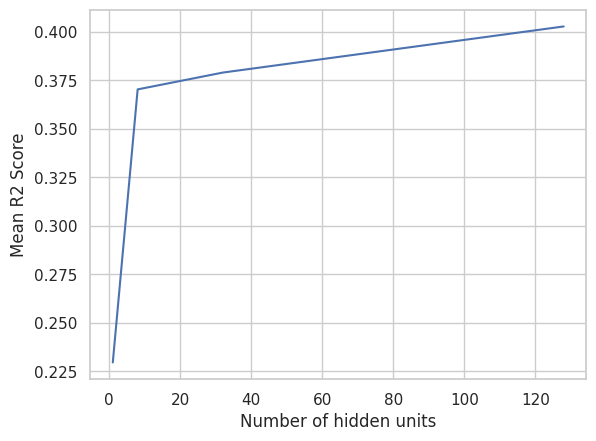

In [62]:
# plot the rscores to H values
plt.plot(H, rscores)
plt.xlabel('Number of hidden units')
plt.ylabel('Mean R2 Score')
plt.show()

In [63]:
# print info to compare with lin reg
print("Most efficient NN Mean R^2 score: " + str(rscores[2]))
print("Mean Time taken: " + str(times[2]))
print("Linear Regression R^2 score: " + str(allr2))
print("Linear Regression Time taken: " + str(linear_reg_time))

Most efficient NN Mean R^2 score: 0.3790031886624224
Mean Time taken: 0.25440144538879395
Linear Regression R^2 score: 0.34860539017166103
Linear Regression Time taken: 0.0016407966613769531


Part 4

In [64]:
# make the train and test data
x = df_selected.drop(columns=['classification target', 'regression target'])
y = df_selected['classification target']
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=4211)

In [65]:
# create a logistic regression model using gradient-descending algorithm and a step size parameter of 0.2.
logreg = SGDClassifier(loss='log_loss', learning_rate='optimal', eta0=0.1)


In [66]:
# train the model and get the mean time taken
temptimes = []
tempacc = []
tempF1 = []
for i in range(3):
    start = time.time()
    logreg.fit(trainX, trainY)
    end = time.time()
    elapsed_time = end - start
    prediction = logreg.predict(testX)
    temptimes.append(elapsed_time)
    tempacc.append(accuracy_score(testY, prediction))
    tempF1.append(f1_score(testY, prediction))
# get the mean time, accuracy and F1 score
lr_mean_time = np.mean(temptimes)
lr_mean_acc = np.mean(tempacc)
lr_mean_f1 = np.mean(tempF1)
# get the standard deviation of time, accuracy and F1 score
sd_time = np.std(temptimes)
sd_acc = np.std(tempacc)
sd_f1 = np.std(tempF1)
# print the results
print("Mean Time taken: " + str(lr_mean_time) + " Standard deviation: " + str(sd_time))
print("Mean Accuracy: " + str(lr_mean_acc) + " Standard deviation: " + str(sd_acc))
print("Mean F1 score: " + str(lr_mean_f1) + " Standard deviation: " + str(sd_f1))


Mean Time taken: 0.03864638010660807 Standard deviation: 0.0033449998875587916
Mean Accuracy: 0.8592278719397363 Standard deviation: 0.006951423286362226
Mean F1 score: 0.9012658432782242 Standard deviation: 0.006971410059145111


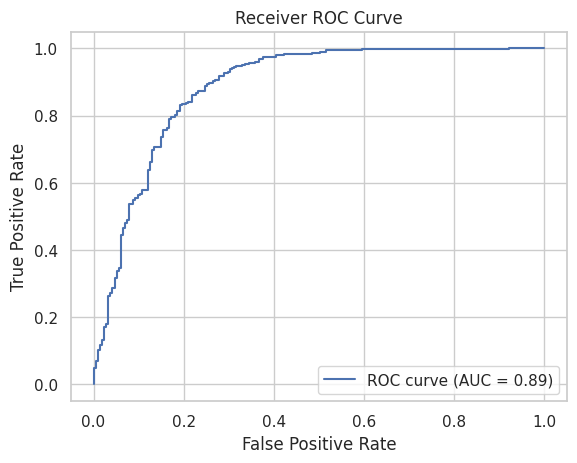

AUC: 0.8853342138780131


In [67]:
# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(testY, logreg.predict_proba(testX)[:,1])

# Calculate the AUC value
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_value))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC value
print('AUC:', auc_value)


In [68]:
# make the train and test data
x = df_selected.drop(columns=['classification target', 'regression target'])
y = df_selected['classification target']
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=4211)

In [69]:
steps = [0.01, 0.2, 0.4, 0.6, 0.8, 0.99]
for step in steps:
    tempacc = []
    tempf1 = []
    logreg = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=step)
    for i in range(3):
        start = time.time()
        logreg.fit(trainX, trainY)
        end = time.time()
        elapsed_time = end - start
        prediction = logreg.predict(testX)
        tempacc.append(accuracy_score(testY, prediction))
        tempF1.append(f1_score(testY, prediction))
    # get the mean accuracy and F1 score
    mean_acc = np.mean(tempacc)
    mean_f1 = np.mean(tempF1)
    print("Step size: " + str(step) + " Accuracy: " + str(mean_acc) + " F1 score: " + str(mean_f1))

Step size: 0.01 Accuracy: 0.878060263653484 F1 score: 0.9092248668220959
Step size: 0.2 Accuracy: 0.8418079096045198 F1 score: 0.9036922366854705
Step size: 0.4 Accuracy: 0.8512241054613936 F1 score: 0.9014629258204784
Step size: 0.6 Accuracy: 0.8418079096045198 F1 score: 0.8998967096164808
Step size: 0.8 Accuracy: 0.812617702448211 F1 score: 0.8932031436067754
Step size: 0.99 Accuracy: 0.8262711864406779 F1 score: 0.8911163937037815


7.2

In [70]:
# create ffnn models for classification with the same hidden layers as the regression models
mlp1 = MLPClassifier(hidden_layer_sizes=(1,1,1), early_stopping=True)
mlp2 = MLPClassifier(hidden_layer_sizes=(8,8,8), early_stopping=True)
mlp3 = MLPClassifier(hidden_layer_sizes=(32,32,32), early_stopping=True)
mlp4 = MLPClassifier(hidden_layer_sizes=(128,128,128), early_stopping=True)

H = [1, 8, 32, 128]
f1scores = []
accs = []
times = []

In [71]:
tempacc = []
tempf1 = []
temptime = []
for i in range(3):
    # train model 1 and get its training time
    start = time.time()
    mlp1.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp1pred = mlp1.predict(testX)
    # get f1 score
    mlp1f1 = f1_score(testY, mlp1pred)
    tempf1.append(mlp1f1)
    # get accuracy
    mlp1acc = accuracy_score(testY, mlp1pred)
    tempacc.append(mlp1acc)
# print time, accuracy and f1 score
mean_acc = np.mean(tempacc)
mean_f1 = np.mean(tempf1)
mean_time = np.mean(temptime)
times.append(mean_time)
f1scores.append(mean_f1)
accs.append(mean_acc)
print("Mean Time taken for model 1: " + str(mean_time))
print("Mean Accuracy for model 1: " + str(mean_acc))
print("Mean F1 score for model 1: " + str(mean_f1))

Mean Time taken for model 1: 0.12121772766113281
Mean Accuracy for model 1: 0.565442561205273
Mean F1 score for model 1: 0.5473216763807938


In [72]:
tempacc = []
tempf1 = []
temptime = []
for i in range(3):
    # train model 2 and get its training time
    start = time.time()
    mlp2.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp2pred = mlp2.predict(testX)
    # get f1 score
    mlp2f1 = f1_score(testY, mlp2pred)
    tempf1.append(mlp2f1)
    # get accuracy
    mlp2acc = accuracy_score(testY, mlp2pred)
    tempacc.append(mlp2acc)
# print time, accuracy and f1 score
mean_acc = np.mean(tempacc)
mean_f1 = np.mean(tempf1)
mean_time = np.mean(temptime)
times.append(mean_time)
f1scores.append(mean_f1)
accs.append(mean_acc)
print("Mean Time taken for model 2: " + str(mean_time))
print("Mean Accuracy for model 2: " + str(mean_acc))
print("Mean F1 score for model 2: " + str(mean_f1))


Mean Time taken for model 2: 0.28888432184855145
Mean Accuracy for model 2: 0.8747645951035782
Mean F1 score for model 2: 0.914299977720345


In [73]:
tempacc = []
tempf1 = []
temptime = []
for i in range(3):
    # train model 3 and get its training time
    start = time.time()
    mlp3.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp3pred = mlp3.predict(testX)
    # get f1 score
    mlp3f1 = f1_score(testY, mlp3pred)
    tempf1.append(mlp3f1)
    # get accuracy
    mlp3acc = accuracy_score(testY, mlp3pred)
    tempacc.append(mlp3acc)
# print time, accuracy and f1 score
mean_acc = np.mean(tempacc)
mean_f1 = np.mean(tempf1)
mean_time = np.mean(temptime)
times.append(mean_time)
f1scores.append(mean_f1)
accs.append(mean_acc)
print("Mean Time taken for model 3: " + str(mean_time))
print("Mean Accuracy for model 3: " + str(mean_acc))
print("Mean F1 score for model 3: " + str(mean_f1))

Mean Time taken for model 3: 0.33731834093729657
Mean Accuracy for model 3: 0.8818267419962336
Mean F1 score for model 3: 0.9187939836306042


In [74]:
tempacc = []
tempf1 = []
temptime = []
for i in range(3):
    # train model 4 and get its training time
    start = time.time()
    mlp4.fit(trainX, trainY)
    end = time.time()
    temptime.append(end - start)
    # make predictions
    mlp4pred = mlp4.predict(testX)
    # get f1 score
    mlp4f1 = f1_score(testY, mlp4pred)
    tempf1.append(mlp4f1)
    # get accuracy
    mlp4acc = accuracy_score(testY, mlp4pred)
    tempacc.append(mlp4acc)
# print time, accuracy and f1 score
mean_acc = np.mean(tempacc)
mean_f1 = np.mean(tempf1)
mean_time = np.mean(temptime)
times.append(mean_time)
f1scores.append(mean_f1)
accs.append(mean_acc)
print("Mean Time taken for model 4: " + str(mean_time))
print("Mean Accuracy for model 4: " + str(mean_acc))
print("Mean F1 score for model 4: " + str(mean_f1))

Mean Time taken for model 4: 1.1054277420043945
Mean Accuracy for model 4: 0.8738229755178907
Mean F1 score for model 4: 0.9129310454454197


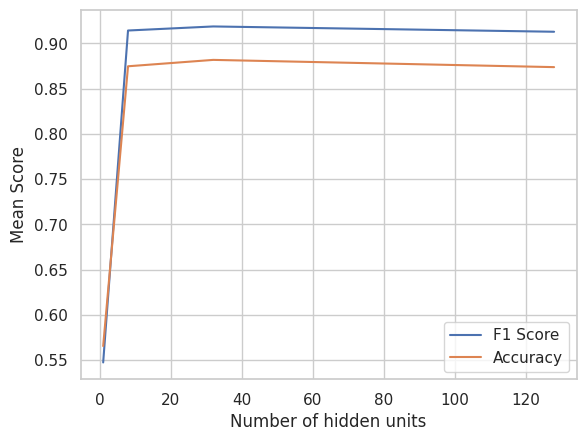

In [75]:
# plot the f1 and accuracy scores to H values
plt.plot(H, f1scores, label='F1 Score')
plt.plot(H, accs, label='Accuracy')
plt.xlabel('Number of hidden units')
plt.ylabel('Mean Score')
plt.legend(loc='lower right')
plt.show()


In [76]:
# print info to compare with lin reg
print("Most efficient NN Mean Accuracy: " + str(accs[2]))
print("Mean F1 score: " + str(f1scores[2]))
print("Mean Time taken: " + str(times[2]))
print("Logistic Regression Mean Accuracy: " + str(lr_mean_acc))
print("Logistic Regression Mean F1 score: " + str(lr_mean_f1))
print("Logistic Regression Mean Time taken: " + str(lr_mean_time))

Most efficient NN Mean Accuracy: 0.8818267419962336
Mean F1 score: 0.9187939836306042
Mean Time taken: 0.33731834093729657
Logistic Regression Mean Accuracy: 0.8592278719397363
Logistic Regression Mean F1 score: 0.9012658432782242
Logistic Regression Mean Time taken: 0.03864638010660807


Part 5

In [86]:
# split into num and cat
non_ord_features = cat_features.drop(columns=['C2', 'C5', 'classification target'])
non_num = cat_features.drop(columns=['classification target']) 
class_target = df_train['classification target']

# create relevant preprocessors for A, B and C
preprocessor_A = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), num_features.columns),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder())]), non_num.columns)
    ]
)

preprocessor_B = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())]), num_features.columns),
        ('ord', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OrdinalEncoder())]), ord_features.columns),
        ('non_ord', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder())]), non_ord_features.columns)

    ]
)

preprocessor_C = ColumnTransformer(
    transformers=[
        ('disc', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())]), disc_features.columns), 
        ('cont', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), cont_features.columns),
        ('ord', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OrdinalEncoder())]), ord_features.columns),
        ('non_ord', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder())]), non_ord_features.columns)
    ]
)

# create nn pipeline
pipeline = Pipeline(steps=[('classifier', MLPClassifier(hidden_layer_sizes=(32,32,32), early_stopping=True))])

# pipeline with feature selection
pipeline_C = Pipeline(steps=[
    ('vthresh', VarianceThreshold()),
    ('selector', SelectKBest(score_func=mutual_info_classif, k=40)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(32,32,32), early_stopping=True))
])


# preprocess and split data
x = df_train.drop(columns=['classification target'])
# encode the classification target
le = LabelEncoder()
y = le.fit_transform(df_train['classification target'])

x_A = preprocessor_A.fit_transform(x)
x_B = preprocessor_B.fit_transform(x)
x_C = preprocessor_C.fit_transform(x)

# Split train and test data
trainX_A, testX_A, trainY_A, testY_A = train_test_split(x_A, y, test_size=0.2, random_state=4211)
trainX_B, testX_B, trainY_B, testY_B = train_test_split(x_B, y, test_size=0.2, random_state=4211)
trainX_C, testX_C, trainY_C, testY_C = train_test_split(x_C, y, test_size=0.2, random_state=4211)

# run pipeline A
start = time.time()
pipeline.fit(trainX_A, trainY_A)
end = time.time()
elapsed_time = end - start
# get f1 score
prediction = pipeline.predict(testX_A)
f1 = f1_score(testY_A, prediction)
# get accuracy 
acc = accuracy_score(testY_A, prediction)
print("F1 score for pipeline A: " + str(f1))
print("Accuracy for pipeline A: " + str(acc))

# run pipeline B
start = time.time()
pipeline.fit(trainX_B, trainY_B)
end = time.time()
elapsed_time = end - start
# get f1 score
prediction = pipeline.predict(testX_B)
f1 = f1_score(testY_B, prediction)
# get accuracy
acc = accuracy_score(testY_B, prediction)
print("F1 score for pipeline B: " + str(f1))
print("Accuracy for pipeline B: " + str(acc))

# pipeline C
start = time.time()
pipeline_C.fit(trainX_C, trainY_C)
end = time.time()
elapsed_time = end - start
# get f1 score
prediction = pipeline_C.predict(testX_C)
f1 = f1_score(testY_C, prediction)
# get accuracy
acc = accuracy_score(testY_C, prediction)
print("F1 score for pipeline C: " + str(f1))
print("Accuracy for pipeline C: " + str(acc))



F1 score for pipeline A: 0.9206963249516441
Accuracy for pipeline A: 0.884180790960452
F1 score for pipeline B: 0.8956937799043062
Accuracy for pipeline B: 0.846045197740113
F1 score for pipeline C: 0.9215876089060987
Accuracy for pipeline C: 0.885593220338983


Grid Search

In [78]:
# make the train and test data
x = df_selected.drop(columns=['classification target', 'regression target'])
y = df_selected['classification target']
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=4211)

# Define the hyperparameters that you want to tune
param_grid = {
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'learning_rate': ['invscaling', 'adaptive', 'constant'],
    'alpha': [0.001, 0.01, 0.1]
}

mlp = MLPClassifier(hidden_layer_sizes=(32,32,32), early_stopping=True)

grid_search = GridSearchCV(mlp, param_grid, cv=10)
grid_search.fit(trainX, trainY)

# get best params
best_params = grid_search.best_params
print("Best hyperparameters:", best_params)

# try params on data
better_mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 32), activation=best_params['activation'], solver=best_params['solver'], learning_rate=best_params['learning_rate'], alpha=best_params['alpha'])
better_mlp.fit(trainX, trainY)
accuracy = better_mlp.score(testX, testY)
print("Accuracy:", accuracy)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status

KeyboardInterrupt: 